# B — PML tuning (project notebook)

This notebook is **project-native**: it uses your `core/` and `operators/` modules.

It:
- fixes the physical domain to **1.0 × 1.0** and the grid to **n = 201** points per axis,
- sweeps PML **thickness** `npml` and **strength** via `eta` where `strength = eta * omega`,
- plots **Re/Im** (not modulus), plots **PML strength** `|sigma|`, and shows stretch factors on the **Re/Im axis**,
- computes a simple **reflection score** and visualizes a heatmap to pick a good `npml` range.

**About 4th/6th/8th order Laplacian:** your current `operators/assemble.py` uses a 2nd-order stencil.
So the PML tuning is fully project-native, and the FD-order comparison at the end is an **independent reference**
(to show what higher-order changes qualitatively).

## 0) Imports and path setup

Run from the project root (the folder that contains `src/`).

In [8]:
# --- standard ---
import numpy as np
import sys
from pathlib import Path

# --- make src importable (run notebook from project root!) ---
PROJECT_ROOT = Path.cwd()
SRC_ROOT = PROJECT_ROOT / "src"
if str(SRC_ROOT) not in sys.path:
    sys.path.insert(0, str(SRC_ROOT))

# --- core ---
from core.config import Grid2D, HelmholtzConfig, PMLConfig
from core.cases import make_default_cases
from core.medium import build_medium
from core.rhs import assemble_rhs

# --- operators ---
from operators.solve import solve_helmholtz
from operators.pml import build_pml_profiles

print("Imports OK")


Imports OK


## 1) Fixed physical domain and grid: n = 201 on 1.0 × 1.0

In [9]:
Lx = Ly = 1.0
n = 257
grid = Grid2D(nx=n, ny=n, lx=Lx, ly=Ly)

cases = make_default_cases()
case = cases["constant"]   # c = 1

omega = 64.0

cfg_base = HelmholtzConfig(
    omega=omega,
    grid=grid,
    pml=None,
    ppw_target=10.0,
)

X, Y = grid.mesh()
c = build_medium(cfg_base, case, X, Y)
f = assemble_rhs(cfg_base, case, X, Y)


KeyError: 'constant'

## 2) Choose a case + build `c(x,y)` and RHS `f`

In [14]:

cases = make_default_cases()
print("Available cases:", list(cases.keys()))

Available cases: ['const']


In [15]:

CASE_NAME = "constant" if "constant" in cases else list(cases.keys())[0]
case = cases[CASE_NAME]
print("Using case:", CASE_NAME, case)

Using case: const CaseConfig(name='const', c0=1.0, c_func=None, rhs_func=None)


In [16]:

omega = 32.0  # change/sweep later if you want

cfg0 = HelmholtzConfig(omega=omega, grid=grid, pml=None)
X, Y = cfg0.grid.mesh()

c = build_medium(cfg0, case, X, Y)     # (nx, ny)
f = assemble_rhs(cfg0, case, X, Y)     # (N,) or (nx, ny)

print("c.shape:", c.shape, "c.min/max:", float(np.min(c)), float(np.max(c)))
print("f.shape:", f.shape, "dtype:", f.dtype)

c.shape: (257, 257) c.min/max: 1.0 1.0
f.shape: (66049,) dtype: complex128


## 3) Diagnostics helpers: Re/Im plots, sigma plots, reflection score

In [17]:

def plot_re_im(U: np.ndarray, title: str):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    im0 = ax[0].imshow(U.real, origin="lower")
    ax[0].set_title(f"Re(u) — {title}")
    plt.colorbar(im0, ax=ax[0], fraction=0.046)

    im1 = ax[1].imshow(U.imag, origin="lower")
    ax[1].set_title(f"Im(u) — {title}")
    plt.colorbar(im1, ax=ax[1], fraction=0.046)
    plt.show()

def sigma_strength_field(sig_x: np.ndarray, sig_y: np.ndarray) -> np.ndarray:
    Sx = sig_x[None, :].repeat(sig_y.size, axis=0)
    Sy = sig_y[:, None].repeat(sig_x.size, axis=1)
    return np.sqrt(Sx**2 + Sy**2)

def plot_sigma(sig_x: np.ndarray, sig_y: np.ndarray, title: str):
    Smag = sigma_strength_field(sig_x, sig_y)
    plt.figure(figsize=(5,4))
    plt.imshow(Smag, origin="lower")
    plt.title(title + " — |sigma(x,y)|")
    plt.colorbar(fraction=0.046)
    plt.show()

def plot_stretch_re_im(sx: np.ndarray, sy: np.ndarray, title: str):
    plt.figure(figsize=(5,4))
    plt.scatter(sx.real, sx.imag, s=8, alpha=0.7, label="s_x")
    plt.scatter(sy.real, sy.imag, s=8, alpha=0.7, label="s_y")
    plt.axhline(0, linewidth=1)
    plt.axvline(0, linewidth=1)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(title + " — stretch factors (Re/Im)")
    plt.xlabel("Re(s)")
    plt.ylabel("Im(s)")
    plt.legend()
    plt.show()

def reflection_score(U: np.ndarray, npml: int, ring: int = 8) -> float:
    # core = grid with npml stripped off each side
    core = U[npml:-npml, npml:-npml] if npml > 0 else U
    ny, nx = core.shape
    if 2*ring >= min(nx, ny):
        return np.nan

    mask = np.zeros_like(core, dtype=bool)
    mask[:ring, :] = True
    mask[-ring:, :] = True
    mask[:, :ring] = True
    mask[:, -ring:] = True

    E_ring = float(np.sum(np.abs(core[mask])**2))
    E_in = float(np.sum(np.abs(core[~mask])**2) + 1e-30)
    return E_ring / E_in

## 4) One PML run (m fixed to 2)

Your parameterization:
- `PMLConfig(thickness=npml, power=m, strength=strength)`
- with `strength = eta * omega`.

We fix `m = 2` here.

In [18]:

npml = 20
eta = 1.5
m = 2

strength = float(eta) * float(omega)

cfg = HelmholtzConfig(
    omega=float(omega),
    grid=grid,
    pml=PMLConfig(thickness=int(npml), strength=float(strength), power=float(m)),
)

sol = solve_helmholtz(cfg, c=c, f=f, return_matrix=False, return_residual=True)
U = sol["U"]

print("Residual norms:", sol.get("norms", {}))
print("Reflection score:", reflection_score(U, npml=npml, ring=8))

Residual norms: {'||r||2': 2.16435344937313e-14, '||f||2': 1.0, '||r||2/||f||2': 2.16435344937313e-14, '||u||2': 0.0003517530798976381, '||r||inf': 1.3627692615098487e-14}
Reflection score: 0.11332622263912649


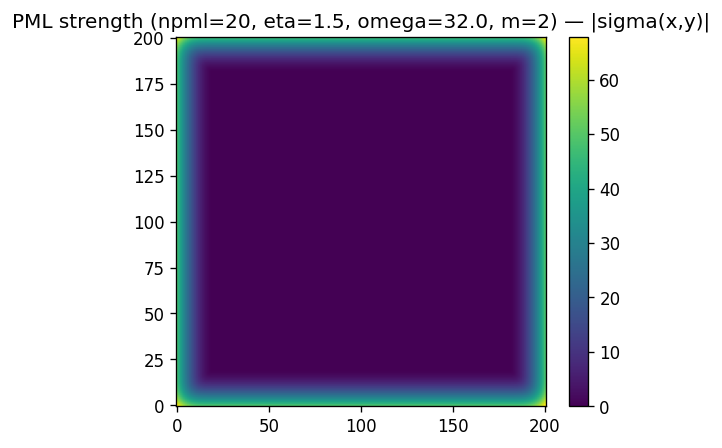

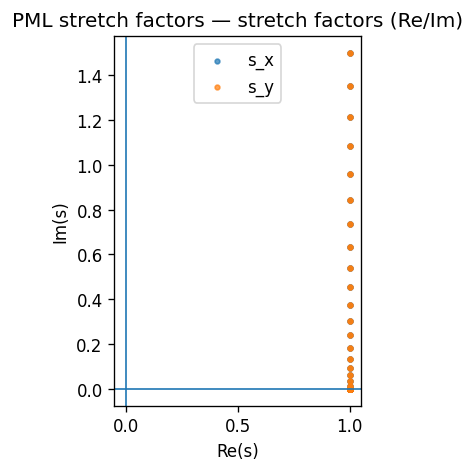

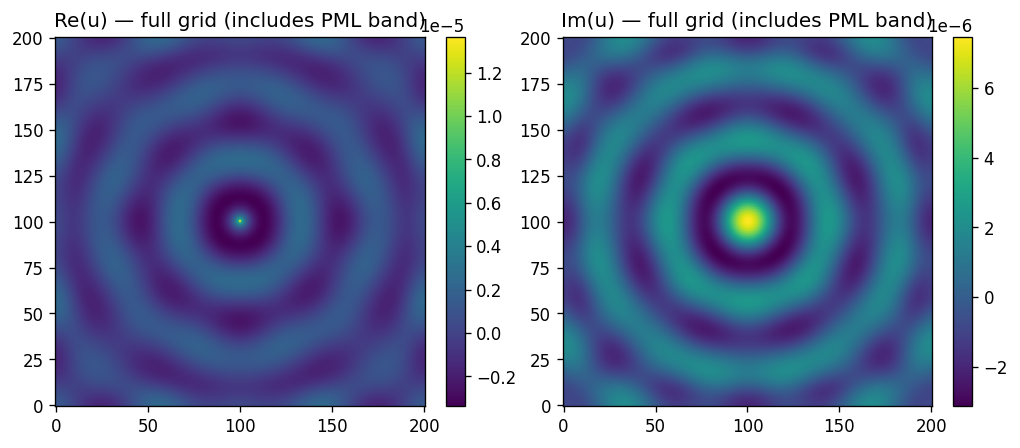

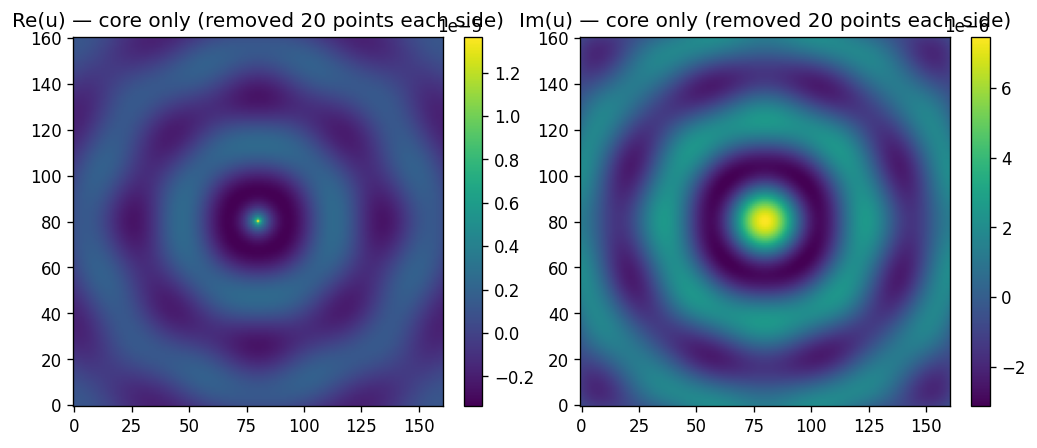

In [8]:

sig_x, sig_y, sx, sy = build_pml_profiles(cfg, c_ref=float(np.min(c)))

plot_sigma(sig_x, sig_y, title=f"PML strength (npml={npml}, eta={eta}, omega={omega}, m={m})")
plot_stretch_re_im(sx, sy, title="PML stretch factors")

plot_re_im(U, title="full grid (includes PML band)")
plot_re_im(U[npml:-npml, npml:-npml], title=f"core only (removed {npml} points each side)")

## 5) Sweep PML thickness × eta (strength)

Produces a heatmap of reflection score. Lower is better.

In [19]:

def run_pml_score(npml: int, eta: float, omega: float) -> float:
    strength = float(eta) * float(omega)
    cfg = HelmholtzConfig(
        omega=float(omega),
        grid=grid,
        pml=PMLConfig(thickness=int(npml), strength=float(strength), power=2.0),
    )
    sol = solve_helmholtz(cfg, c=c, f=f, return_matrix=False, return_residual=False)
    return reflection_score(sol["U"], npml=npml, ring=8)

npml_list = [10, 15, 20, 25, 30]
eta_list  = [0.5, 1.0, 1.5, 2.0, 3.0]

scores = np.zeros((len(npml_list), len(eta_list)), dtype=float)
for i, a in enumerate(npml_list):
    for j, e in enumerate(eta_list):
        s = run_pml_score(npml=a, eta=e, omega=omega)
        scores[i, j] = s
        print(f"npml={a:>3d}, eta={e:>4.1f} -> score={s:.3e}")

npml= 10, eta= 0.5 -> score=1.486e-01
npml= 10, eta= 1.0 -> score=1.392e-01
npml= 10, eta= 1.5 -> score=1.262e-01
npml= 10, eta= 2.0 -> score=1.120e-01
npml= 10, eta= 3.0 -> score=8.634e-02
npml= 15, eta= 0.5 -> score=1.920e-01
npml= 15, eta= 1.0 -> score=1.377e-01
npml= 15, eta= 1.5 -> score=9.810e-02
npml= 15, eta= 2.0 -> score=7.479e-02
npml= 15, eta= 3.0 -> score=5.411e-02
npml= 20, eta= 0.5 -> score=2.122e-01
npml= 20, eta= 1.0 -> score=1.446e-01
npml= 20, eta= 1.5 -> score=1.133e-01
npml= 20, eta= 2.0 -> score=9.552e-02
npml= 20, eta= 3.0 -> score=7.518e-02
npml= 25, eta= 0.5 -> score=1.787e-01
npml= 25, eta= 1.0 -> score=1.407e-01
npml= 25, eta= 1.5 -> score=1.176e-01
npml= 25, eta= 2.0 -> score=1.017e-01
npml= 25, eta= 3.0 -> score=8.291e-02
npml= 30, eta= 0.5 -> score=1.060e-01
npml= 30, eta= 1.0 -> score=9.937e-02
npml= 30, eta= 1.5 -> score=9.408e-02
npml= 30, eta= 2.0 -> score=9.087e-02
npml= 30, eta= 3.0 -> score=8.661e-02


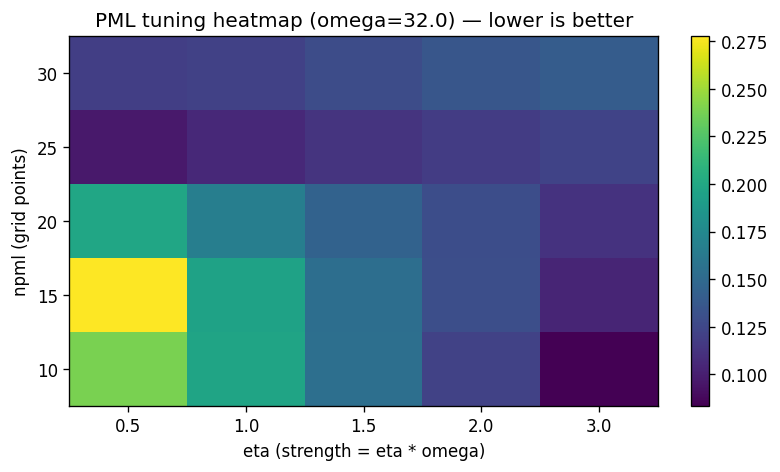

Best (in this sweep): npml=10, eta=3.0, score=8.341e-02
npml= 10 -> thickness=0.0500 (~0.25 λ_min)
npml= 15 -> thickness=0.0750 (~0.38 λ_min)
npml= 20 -> thickness=0.1000 (~0.51 λ_min)
npml= 25 -> thickness=0.1250 (~0.64 λ_min)
npml= 30 -> thickness=0.1500 (~0.76 λ_min)


In [10]:

plt.figure(figsize=(7, 4))
plt.imshow(scores, origin="lower", aspect="auto")
plt.xticks(range(len(eta_list)), [str(e) for e in eta_list])
plt.yticks(range(len(npml_list)), [str(v) for v in npml_list])
plt.xlabel("eta (strength = eta * omega)")
plt.ylabel("npml (grid points)")
plt.title(f"PML tuning heatmap (omega={omega}) — lower is better")
plt.colorbar(fraction=0.046)
plt.show()

best = np.unravel_index(np.nanargmin(scores), scores.shape)
best_npml = npml_list[best[0]]
best_eta  = eta_list[best[1]]
print(f"Best (in this sweep): npml={best_npml}, eta={best_eta}, score={scores[best]:.3e}")

lam_min = 2*np.pi*float(np.min(c))/float(omega)
for npml_ in npml_list:
    thick = npml_ * float(max(grid.hx, grid.hy))
    print(f"npml={npml_:>3d} -> thickness={thick:.4f} (~{thick/lam_min:.2f} λ_min)")

## 6) Lock-in check: visualize the best candidate

Residual norms: {'||r||2': 3.238936844283185e-14, '||f||2': 1.0, '||r||2/||f||2': 3.238936844283185e-14, '||u||2': 0.0005675801571795686, '||r||inf': 2.1641563564719855e-14}
Reflection score: 0.08633835515464147


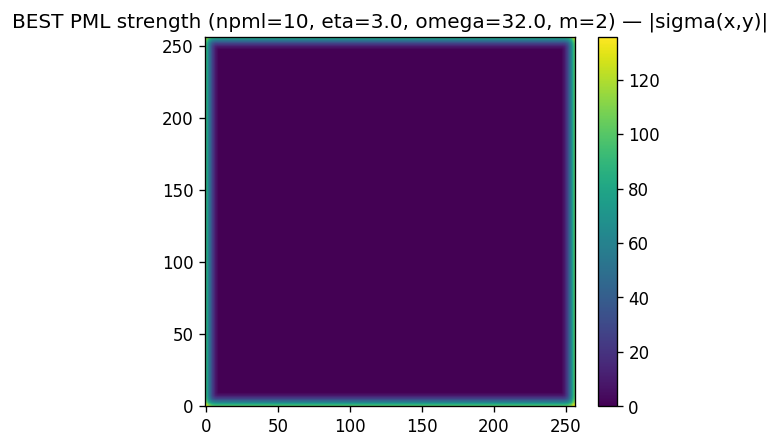

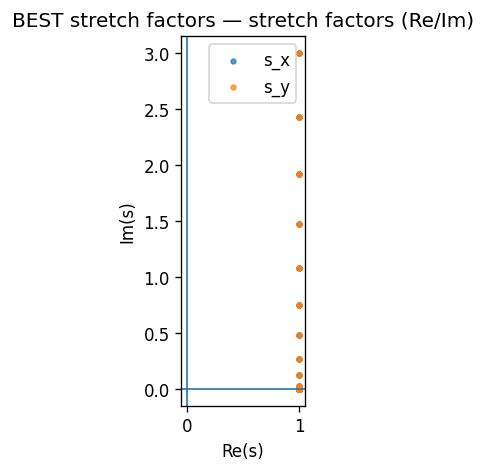

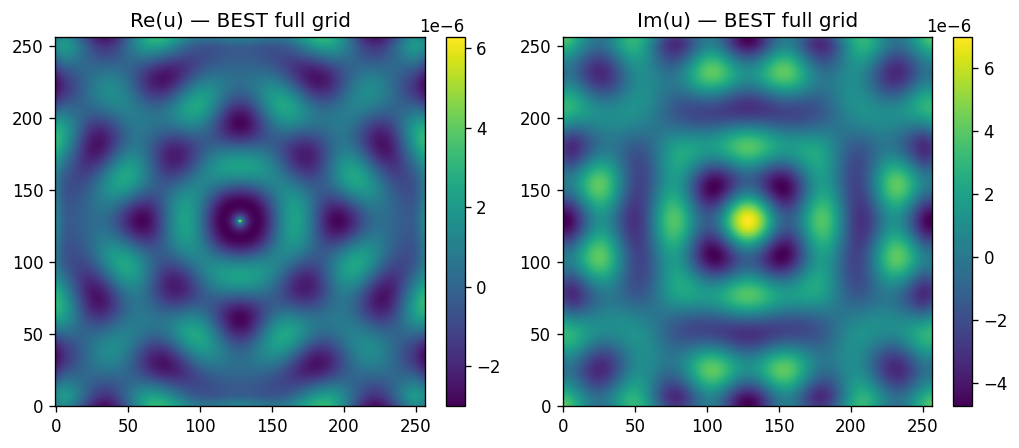

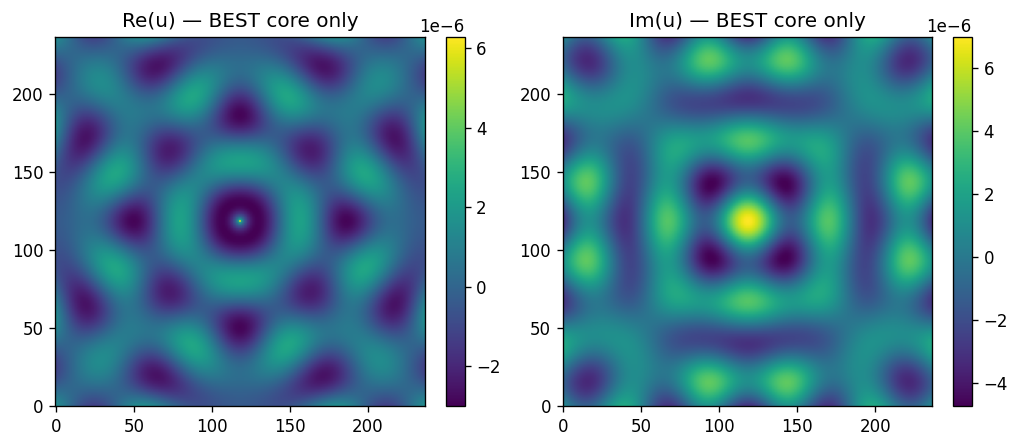

In [20]:

npml = int(best_npml)
eta = float(best_eta)
strength = eta * omega

cfg_best = HelmholtzConfig(
    omega=float(omega),
    grid=grid,
    pml=PMLConfig(thickness=npml, strength=float(strength), power=2.0),
)

sol = solve_helmholtz(cfg_best, c=c, f=f, return_matrix=False, return_residual=True)
U = sol["U"]
print("Residual norms:", sol.get("norms", {}))
print("Reflection score:", reflection_score(U, npml=npml, ring=8))

sig_x, sig_y, sx, sy = build_pml_profiles(cfg_best, c_ref=float(np.min(c)))

plot_sigma(sig_x, sig_y, title=f"BEST PML strength (npml={npml}, eta={eta}, omega={omega}, m=2)")
plot_stretch_re_im(sx, sy, title="BEST stretch factors")
plot_re_im(U, title="BEST full grid")
plot_re_im(U[npml:-npml, npml:-npml], title="BEST core only")

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1) Region masks + energy metrics
# ----------------------------
def core_slices(npml: int, n: int):
    return (slice(npml, n-npml), slice(npml, n-npml))

def ring_mask(shape, ring: int):
    ny, nx = shape
    m = np.zeros((ny, nx), dtype=bool)
    m[:ring, :] = True
    m[-ring:, :] = True
    m[:, :ring] = True
    m[:, -ring:] = True
    return m

def energy(z):
    return float(np.sum(np.abs(z)**2))

def band_energy_along_x(U, x0, x1, y0, y1):
    return energy(U[y0:y1, x0:x1])

def pml_decay_profile(U, npml: int):
    """
    Measures mean |u|^2 as a function of distance into the PML
    on each side. If PML works, these curves should decay strongly.
    """
    n = U.shape[0]
    cs = core_slices(npml, n)
    # core boundary indices
    left0  = 0
    left1  = npml
    right0 = n - npml
    right1 = n
    bot0   = 0
    bot1   = npml
    top0   = n - npml
    top1   = n

    prof = {
        "left":  np.zeros(npml),
        "right": np.zeros(npml),
        "bottom":np.zeros(npml),
        "top":   np.zeros(npml),
    }

    # For each depth d=0..npml-1, measure the strip at that depth
    # d=0 is at the core interface, d=npml-1 is at the outer boundary.
    for d in range(npml):
        # left strip: x = npml-1-d (moving outward)
        x = npml - 1 - d
        prof["left"][d] = float(np.mean(np.abs(U[cs[0], x])**2))

        # right strip: x = n-npml + d
        x = (n - npml) + d
        prof["right"][d] = float(np.mean(np.abs(U[cs[0], x])**2))

        # bottom strip: y = npml-1-d
        y = npml - 1 - d
        prof["bottom"][d] = float(np.mean(np.abs(U[y, cs[1]])**2))

        # top strip: y = (n-npml) + d
        y = (n - npml) + d
        prof["top"][d] = float(np.mean(np.abs(U[y, cs[1]])**2))

    return prof

def reflection_metrics(U, npml: int, ring: int = 8, outer_ring: int = 8):
    """
    Compute a small set of metrics so you can see what is actually failing.

    M1: "core ring" metric (your current style): energy near core boundary / core interior
    M2: "outer ring" metric: energy near *outer* boundary / core interior
    M3: "PML decay ratio": mean energy at PML outer boundary / mean energy at PML interface
    """
    n = U.shape[0]
    cs = core_slices(npml, n)
    core = U[cs[0], cs[1]]

    # M1: ring near core boundary
    m_core_ring = ring_mask(core.shape, ring=ring)
    E_core_ring = energy(core[m_core_ring])
    E_core_in   = energy(core[~m_core_ring]) + 1e-30
    M1 = E_core_ring / E_core_in

    # M2: ring near outer boundary (full grid)
    m_outer = ring_mask(U.shape, ring=outer_ring)
    E_outer = energy(U[m_outer])
    M2 = E_outer / E_core_in

    # M3: decay ratio (interface vs outer boundary)
    # interface strips: immediate PML cells adjacent to core
    # outer strips: outermost PML boundary cells
    if npml > 0:
        # interface bands
        left_int  = npml
        right_int = n - npml - 1
        bot_int   = npml
        top_int   = n - npml - 1

        E_int = (
            float(np.mean(np.abs(U[cs[0], left_int])**2)) +
            float(np.mean(np.abs(U[cs[0], right_int])**2)) +
            float(np.mean(np.abs(U[bot_int, cs[1]])**2)) +
            float(np.mean(np.abs(U[top_int, cs[1]])**2))
        ) / 4.0

        # outer boundary bands
        E_out = (
            float(np.mean(np.abs(U[cs[0], 0])**2)) +
            float(np.mean(np.abs(U[cs[0], n-1])**2)) +
            float(np.mean(np.abs(U[0, cs[1]])**2)) +
            float(np.mean(np.abs(U[n-1, cs[1]])**2))
        ) / 4.0

        M3 = E_out / (E_int + 1e-30)
    else:
        M3 = np.nan

    return {"M1_core_ring": M1, "M2_outer_ring": M2, "M3_decay_ratio": M3}


# ----------------------------
# 2) Visual debug plots
# ----------------------------
def plot_re_im(U, title):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    a0 = ax[0].imshow(U.real, origin="lower")
    ax[0].set_title(f"Re(u) — {title}")
    plt.colorbar(a0, ax=ax[0], fraction=0.046)
    a1 = ax[1].imshow(U.imag, origin="lower")
    ax[1].set_title(f"Im(u) — {title}")
    plt.colorbar(a1, ax=ax[1], fraction=0.046)
    plt.show()

def plot_lineouts(U, npml: int):
    """
    Plot center lineouts across the domain to spot reflected waves
    (standing-wave ripples, phase jumps near PML interface, etc.)
    """
    n = U.shape[0]
    mid = n//2
    x = np.arange(n)
    plt.figure(figsize=(10,4))
    plt.plot(x, U.real[mid, :], label="Re(u) along y=mid")
    plt.plot(x, U.imag[mid, :], label="Im(u) along y=mid")
    for v in [npml, n-npml-1]:
        plt.axvline(v, linestyle="--", linewidth=1)
    plt.title("Center horizontal lineout (dashed = PML interfaces)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(x, U.real[:, mid], label="Re(u) along x=mid")
    plt.plot(x, U.imag[:, mid], label="Im(u) along x=mid")
    for v in [npml, n-npml-1]:
        plt.axvline(v, linestyle="--", linewidth=1)
    plt.title("Center vertical lineout (dashed = PML interfaces)")
    plt.legend()
    plt.show()

def plot_pml_decay(prof):
    """
    prof[d=0] is near core interface; d increases moving outward.
    """
    d = np.arange(len(next(iter(prof.values()))))
    plt.figure(figsize=(8,4))
    for k,v in prof.items():
        plt.semilogy(d, v + 1e-30, label=k)
    plt.title("Mean |u|^2 vs depth into PML (log scale)")
    plt.xlabel("depth into PML (0=interface, increasing outward)")
    plt.ylabel("mean |u|^2")
    plt.legend()
    plt.show()


# ----------------------------
# 3) One-call debugger: run, print metrics, plot, compare no-PML
# ----------------------------
def debug_pml_run(
    solve_fn, build_profiles_fn,
    cfg, c, f,
    npml: int,
    compare_no_pml: bool = True,
):
    # solve with PML
    sol = solve_fn(cfg, c=c, f=f, return_matrix=False, return_residual=True)
    U = sol["U"]
    norms = sol.get("norms", {})

    print("Residual norms:", norms)
    mets = reflection_metrics(U, npml=npml, ring=8, outer_ring=8)
    print("Metrics:")
    for k,v in mets.items():
        print(f"  {k}: {v:.3e}")

    # plots
    plot_re_im(U, "full grid")
    if npml > 0:
        plot_re_im(U[npml:-npml, npml:-npml], "core only")
    plot_lineouts(U, npml=npml)

    prof = pml_decay_profile(U, npml=npml) if npml > 0 else None
    if prof is not None:
        plot_pml_decay(prof)

    # stretch/sigma plots (if your build_profiles returns these)
    try:
        sig_x, sig_y, sx, sy = build_profiles_fn(cfg, c_ref=float(np.min(c)))
        # sigma magnitude
        Smag = np.sqrt(sig_x[None,:]**2 + sig_y[:,None]**2)
        plt.figure(figsize=(5,4))
        plt.imshow(Smag, origin="lower")
        plt.title("|sigma(x,y)|")
        plt.colorbar(fraction=0.046)
        plt.show()

        # stretch factors in complex plane
        plt.figure(figsize=(5,4))
        plt.scatter(sx.real, sx.imag, s=8, alpha=0.6, label="s_x")
        plt.scatter(sy.real, sy.imag, s=8, alpha=0.6, label="s_y")
        plt.axhline(0, linewidth=1); plt.axvline(0, linewidth=1)
        plt.gca().set_aspect("equal", adjustable="box")
        plt.title("Stretch factors (Re/Im plane)")
        plt.xlabel("Re"); plt.ylabel("Im")
        plt.legend()
        plt.show()
    except Exception as e:
        print("Could not plot sigma/stretch from build_pml_profiles:", repr(e))

    # optional: compare to "no PML" baseline (same grid, pml=None)
    if compare_no_pml:
        cfg_no = type(cfg)(omega=cfg.omega, grid=cfg.grid, pml=None, ppw_target=getattr(cfg, "ppw_target", 10.0))
        sol0 = solve_fn(cfg_no, c=c, f=f, return_matrix=False, return_residual=False)
        U0 = sol0["U"]
        mets0 = reflection_metrics(U0, npml=0, ring=8, outer_ring=8)  # no core strip
        print("\nNo-PML baseline metrics (same grid):")
        for k,v in mets0.items():
            print(f"  {k}: {v:.3e}")
        print("\nImprovement factors (noPML / PML):")
        for k in ["M2_outer_ring", "M3_decay_ratio"]:
            if np.isfinite(mets[k]) and mets[k] > 0:
                print(f"  {k}: {(mets0[k]/mets[k]):.2f}x")
            else:
                print(f"  {k}: n/a")

    return U, mets


# ---- USAGE (paste this with your existing objects) ----
# U, mets = debug_pml_run(
#     solve_fn=solve_helmholtz,
#     build_profiles_fn=build_pml_profiles,
#     cfg=cfg_best,   # or cfg
#     c=c,
#     f=f,
#     npml=cfg_best.pml.thickness,
#     compare_no_pml=True,
# )


In [5]:
# --- PML parameters ---
npml = 15          # thickness in grid points
eta  = 3.0         # strength factor
m    = 2           # FIXED power

strength = eta * 32.0

cfg_best = HelmholtzConfig(
    omega=32.0,
    grid=grid,
    pml=PMLConfig(
        thickness=npml,
        strength=strength,
        power=m,
    ),
    ppw_target=10.0,
)

print(cfg_best)


NameError: name 'HelmholtzConfig' is not defined

In [2]:
# --- EXACT USAGE: run the debugger on your current configuration ---

# 1) Make sure these exist from your notebook:
#    - cfg_best (or cfg)
#    - c
#    - f
#    - solve_helmholtz
#    - build_pml_profiles

# 2) Choose which config to debug:
cfg_to_debug = cfg_best  # change to cfg if you want

# 3) Extract npml safely (0 if no PML)
npml = int(cfg_to_debug.pml.thickness) if cfg_to_debug.pml is not None else 0

# 4) Run the debugger (prints metrics + makes plots)
U_dbg, metrics_dbg = debug_pml_run(
    solve_fn=solve_helmholtz,
    build_profiles_fn=build_pml_profiles,
    cfg=cfg_to_debug,
    c=c,
    f=f,
    npml=npml,
    compare_no_pml=True,
)

print("\nReturned metrics dict:", metrics_dbg)


NameError: name 'cfg_best' is not defined

## 7) Reference: 4th vs 6th vs 8th order Laplacian (independent)

Your current project assembler does not implement higher-order stencils.
This section shows what changes qualitatively when you do use 4th/6th/8th order stencils.

In [ ]:

import scipy.sparse as sp
import scipy.sparse.linalg as spla

def d2_stencil(order: int):
    if order == 4:
        offs = np.array([-2, -1, 0, 1, 2])
        coefs = np.array([-1, 16, -30, 16, -1]) / 12.0
    elif order == 6:
        offs = np.array([-3, -2, -1, 0, 1, 2, 3])
        coefs = np.array([2, -27, 270, -490, 270, -27, 2]) / 180.0
    elif order == 8:
        offs = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])
        coefs = np.array([-9, 128, -1008, 8064, -14350, 8064, -1008, 128, -9]) / 5040.0
    else:
        raise ValueError("order must be 4, 6, or 8")
    return offs, coefs

def make_1d_d2(n: int, h: float, order: int) -> sp.csr_matrix:
    offs, coefs = d2_stencil(order)
    diags = []
    for off, c_ in zip(offs, coefs):
        diags.append(c_ * np.ones(n - abs(off)))
    D2 = sp.diags(diags, offs, shape=(n, n), format="csr") / (h**2)

    # Dirichlet boundary rows
    for k in [0, n-1]:
        D2[k, :] = 0
        D2[k, k] = 1.0
    return D2

def gaussian_rhs_2d(n: int, h: float, x0=0.5, y0=0.5, width_cells=2.5):
    xs = np.linspace(0, 1.0, n)
    ys = np.linspace(0, 1.0, n)
    X, Y = np.meshgrid(xs, ys, indexing="ij")
    sig = width_cells * h
    f = np.exp(-((X-x0)**2 + (Y-y0)**2)/(2*sig**2))
    return f.astype(np.complex128)

def solve_const_order(n: int, h: float, omega: float, order: int):
    Dxx = make_1d_d2(n, h, order)
    Dyy = make_1d_d2(n, h, order)
    I = sp.eye(n, format="csr")
    Lap = sp.kron(I, Dxx) + sp.kron(Dyy, I)
    A = -Lap - (omega**2) * sp.eye(n*n, format="csr")  # matches (-Δ - k^2)
    f = gaussian_rhs_2d(n, h).reshape(-1)
    u = spla.spsolve(A, f).reshape(n, n)
    return u

for order in [4, 6, 8]:
    Uo = solve_const_order(n=n, h=float(grid.hx), omega=float(omega), order=order)
    plot_re_im(Uo, title=f"REFERENCE constant-coefficient: order={order}")